### ImagesClassificationWithSIFT with zca_whitening_parameter to False and featurewise_std_normalization_parameter to False

In [1]:
## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt

# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)


# import scipy as sio
# print("Scipy Version :"+sio.__version__)
import scipy.io as sio
import os
import shutil
import random
import cv2 as cv
print("OpenCV Version : "+cv.__version__)
from PIL import Image

# To be able to use Warning
import warnings
import sklearn
print("Sklearn Version : "+sklearn.__version__)
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier
import catboost
print("Catboost Version : "+catboost.__version__)
from catboost import CatBoostClassifier
# from utils import plot_confusion_matrix

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
import tensorflow as tf
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)

Python Version :sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.0.5
Seaborn Version :0.10.1
OpenCV Version : 3.4.2
Sklearn Version : 0.23.1
Catboost Version : 0.24


Using TensorFlow backend.


Keras Version : 2.2.4-tf
Tensorflow Version : 2.1.0


In [2]:
images_directory = './images/Images/'
# train_contents = sio.loadmat('./lists/train_list.mat')
# test_contents = sio.loadmat('./lists/test_list.mat')
# file_list = sio.loadmat('./lists/file_list.mat')
train_directory = './images/train/'
test_directory = './images/test/'

### Rename the folder names

In [ ]:
def convert(word):
    return ''.join(x.capitalize() or '_' for x in word.split('_'))

In [ ]:
for root, dirs, files in os.walk(images_directory):
    for count in dirs:
        print(convert(count.split('-')[1].capitalize()))
        os.rename(os.path.join(images_directory, count), os.path.join(images_directory, convert(count.split('-')[1].capitalize())))


### Creation of the  train test directory

In [ ]:
train_dir = './images/train/'
test_dir = './images/test/'


In [ ]:
files = [file for file in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, file))]

In [ ]:
directories = [directory for directory in os.listdir(images_directory)]

In [ ]:
directories

In [ ]:
for directory in directories:
    os.mkdir(train_dir+directory)
    os.mkdir(test_dir+directory)

### Split train test

In [ ]:
directories

In [ ]:
for directory in directories:
    files = [file for file in os.listdir(images_directory+directory) if os.path.isfile(os.path.join(images_directory+directory, file))]
    train_count  = np.round(70/100*len(files))
    test_count = np.round(30/100*len(files))
    rndnums = list(random.sample(range(0, len(files)), len(files)))
    print("len(files)",len(files))
    train_file_index = rndnums[0:int(train_count)+1]
    train_file_name = [files[i] for i in train_file_index]
    test_file_index = rndnums[int(train_count)+1:int(train_count + test_count)+1]
    test_file_name = [files[i] for i in test_file_index]
    for x in train_file_name:
        file = x
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(train_directory+directory, file))
    ##test_files
    for y in test_file_name:
        file = y
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(test_directory+directory, file))

    

In [ ]:
train_file_name

In [3]:
input_directory='./images/'
output_directory='./new_images/'
small_directory_names = [directory for directory in os.listdir(input_directory+'train-small2')]
small_directory_names.sort()
zca_whitening_parameter=False
featurewise_std_normalization_parameter=False
color_mode_parameter='grayscale'
save_prefix_parameter='set1_'
batch_size=2
follow_links=True
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zca_whitening=zca_whitening_parameter,
        featurewise_std_normalization=featurewise_std_normalization_parameter
        )

In [4]:
small_directory_names

['Basset',
 'BouvierDesFlandres',
 'Cardigan',
 'Dingo',
 'FrenchBulldog',
 'OldEnglishSheepdog']

In [5]:
myCategories = dict(enumerate(small_directory_names))

In [6]:
myCategories

{0: 'Basset',
 1: 'BouvierDesFlandres',
 2: 'Cardigan',
 3: 'Dingo',
 4: 'FrenchBulldog',
 5: 'OldEnglishSheepdog'}

In [7]:
train_generator = train_datagen.flow_from_directory(input_directory+'train-small2', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, subset='training', shuffle=False, color_mode=color_mode_parameter)

Found 678 images belonging to 6 classes.


In [8]:
test_generator = train_datagen.flow_from_directory(input_directory+'test-small2', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, shuffle=False, color_mode=color_mode_parameter)

Found 284 images belonging to 6 classes.


In [9]:
train_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

In [10]:
test_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

### Compute the descriptors  and add them with the category into a dataframe

In [11]:
algo_constructor = cv.xfeatures2d.SIFT_create()
def computeDescriptors(mygenerator, mydf, mydescriptors):
    count = 0
    for i in range(len(mygenerator)):
    #next(train_generator)
        for j in range(batch_size):
            img = mygenerator[i][0][j].squeeze()
            imgwithrgb = cv.merge([img, img, img])
            image8bit = cv.normalize(imgwithrgb, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
            keypoints, descriptors = algo_constructor.detectAndCompute(image8bit, None)
            mydf = mydf.append({'Category': mygenerator[i][1][j].tolist().index(1), 'Picture':image8bit, 'Descriptors':descriptors, 'NumberOfDescriptors':descriptors.shape[0]}, ignore_index='True')
            mydescriptors.extend(descriptors)
            count = count + 1
            j = j+1
    i = i+1
    mydf['Category'] = mydf['Category'].map(myCategories) 
    return mydf, mydescriptors

### Train 

In [12]:
train_descriptors_array=[]
train_df, train_descriptors_array=computeDescriptors(train_generator, train_df, train_descriptors_array)

In [ ]:
plt.imshow(train_df['Picture'][0])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(60, 12))
axs[0].set_title('An Original Picture in grayscale  ', fontsize=20)
axs[0].imshow(train_df['Picture'][0], cmap='Greys_r')
axs[1].set_title('Histogram of an original Picture in grayscale ', fontsize=20)
axs[1].set_xlabel('Level of gray', fontsize=20)
axs[1].set_ylabel('Number of pixels', fontsize=20)
axs[1].hist(train_df['Picture'][0].ravel(), 256, [0, 256])


### Test

In [13]:
test_descriptors_array=[]
test_df, test_descriptors_array=computeDescriptors(test_generator, test_df, test_descriptors_array)

In [14]:
print(train_df['NumberOfDescriptors'].sum())

245960


In [15]:
print(test_df['NumberOfDescriptors'].sum())

98958


### Apply a Kmeans to get clusters

In [16]:
# A k-means clustering algorithm who takes 2 parameter which is number
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    # kmeans = KMeans(n_clusters=k, n_init=10)
    mymodel = MiniBatchKMeans(n_clusters=k, n_init=10)
    mymodel.fit(descriptor_list)
    visual_words = mymodel.cluster_centers_
    labels = mymodel.labels_
    silhouette_score = metrics.silhouette_score(descriptor_list, labels)
    calinski_harabasz_score = metrics.calinski_harabasz_score(descriptor_list, labels)
    print('silhouette_score '+str(silhouette_score))
    print('calinski_harabasz_score '+str(calinski_harabasz_score))
    return mymodel, visual_words, labels
# Takes the central points which is visual words
model, visual_words, labels = kmeans(150, train_descriptors_array)

silhouette_score 0.026034515
calinski_harabasz_score 1197.3195843574279


In [17]:
X_train = pd.DataFrame(columns=range(len(visual_words)))
X_test = pd.DataFrame(columns=range(len(visual_words)))

In [18]:
for index, row in train_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)

In [19]:
X_train.fillna(0, inplace=True)

In [ ]:
X_train

In [ ]:
train_df

In [20]:
for index, row in test_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)

In [21]:
X_test.fillna(0, inplace=True)

In [ ]:
X_test

In [22]:
le = LabelEncoder().fit(train_df['Category'])

In [23]:
y_train = le.transform(train_df['Category'])
y_test = le.transform(test_df['Category'])

In [ ]:
y_test

### TSNE

In [24]:
X_train_embedded = TSNE(n_components=2).fit_transform(X_train)
X_train_embedded_df = pd.DataFrame(X_train_embedded, columns=['SIFT1', 'SIFT2'])

In [25]:
X_train_embedded_df['Category'] = train_df['Category']

silhouette_score -0.10206507
calinski_harabasz_score 14.770985237077728


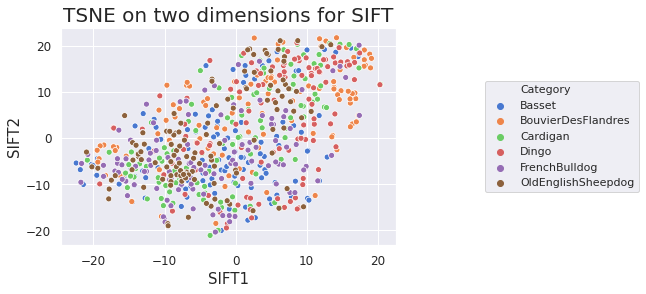

In [26]:
sns.set(palette='muted', color_codes=True, style='darkgrid')
ax = sns.scatterplot(x='SIFT1', y='SIFT2', hue="Category", data=X_train_embedded_df)
ax.set_title('TSNE on two dimensions for SIFT', fontsize=20)
ax.set_xlabel('SIFT1', fontsize=15)
ax.set_ylabel('SIFT2', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax.tick_params(labelsize=12)
silhouette_score = metrics.silhouette_score(X_train_embedded, train_df['Category'])
calinski_harabasz_score = metrics.calinski_harabasz_score(X_train_embedded, train_df['Category'])
print('silhouette_score '+str(silhouette_score))
print('calinski_harabasz_score '+str(calinski_harabasz_score))

### CatBoostClassifier 

In [27]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

In [ ]:
type(small_directory_names)

In [28]:
clf.fit(
    X_train, y_train
    # cat_features=[0, 1, 2]
)

0:	learn: 1.7712693	total: 70.5ms	remaining: 1m 10s
1:	learn: 1.7546360	total: 76.1ms	remaining: 38s
2:	learn: 1.7329873	total: 81.5ms	remaining: 27.1s
3:	learn: 1.7091740	total: 87.1ms	remaining: 21.7s
4:	learn: 1.6922238	total: 92.6ms	remaining: 18.4s
5:	learn: 1.6717591	total: 98.5ms	remaining: 16.3s
6:	learn: 1.6570436	total: 104ms	remaining: 14.7s
7:	learn: 1.6362067	total: 110ms	remaining: 13.6s
8:	learn: 1.6189163	total: 115ms	remaining: 12.7s
9:	learn: 1.5990405	total: 124ms	remaining: 12.3s
10:	learn: 1.5829697	total: 129ms	remaining: 11.6s
11:	learn: 1.5661174	total: 134ms	remaining: 11s
12:	learn: 1.5524564	total: 138ms	remaining: 10.5s
13:	learn: 1.5371375	total: 144ms	remaining: 10.1s
14:	learn: 1.5252254	total: 149ms	remaining: 9.78s
15:	learn: 1.5113104	total: 155ms	remaining: 9.52s
16:	learn: 1.4948653	total: 159ms	remaining: 9.2s
17:	learn: 1.4813858	total: 164ms	remaining: 8.95s
18:	learn: 1.4675499	total: 169ms	remaining: 8.71s
19:	learn: 1.4527820	total: 173ms	remai

164:	learn: 0.4847485	total: 2.81s	remaining: 14.2s
165:	learn: 0.4803976	total: 2.86s	remaining: 14.4s
166:	learn: 0.4770181	total: 2.89s	remaining: 14.4s
167:	learn: 0.4738329	total: 2.92s	remaining: 14.5s
168:	learn: 0.4708734	total: 2.93s	remaining: 14.4s
169:	learn: 0.4674230	total: 2.94s	remaining: 14.4s
170:	learn: 0.4638668	total: 2.96s	remaining: 14.3s
171:	learn: 0.4610705	total: 2.96s	remaining: 14.3s
172:	learn: 0.4591384	total: 2.98s	remaining: 14.2s
173:	learn: 0.4559232	total: 2.98s	remaining: 14.2s
174:	learn: 0.4535922	total: 3s	remaining: 14.1s
175:	learn: 0.4510937	total: 3.03s	remaining: 14.2s
176:	learn: 0.4473268	total: 3.09s	remaining: 14.4s
177:	learn: 0.4443872	total: 3.11s	remaining: 14.4s
178:	learn: 0.4408283	total: 3.12s	remaining: 14.3s
179:	learn: 0.4383056	total: 3.14s	remaining: 14.3s
180:	learn: 0.4356412	total: 3.15s	remaining: 14.3s
181:	learn: 0.4342080	total: 3.16s	remaining: 14.2s
182:	learn: 0.4317025	total: 3.17s	remaining: 14.2s
183:	learn: 0.4

329:	learn: 0.2060102	total: 5.58s	remaining: 11.3s
330:	learn: 0.2052915	total: 5.6s	remaining: 11.3s
331:	learn: 0.2041976	total: 5.61s	remaining: 11.3s
332:	learn: 0.2033280	total: 5.63s	remaining: 11.3s
333:	learn: 0.2031210	total: 5.65s	remaining: 11.3s
334:	learn: 0.2025654	total: 5.66s	remaining: 11.2s
335:	learn: 0.2016108	total: 5.67s	remaining: 11.2s
336:	learn: 0.2008411	total: 5.69s	remaining: 11.2s
337:	learn: 0.2003651	total: 5.7s	remaining: 11.2s
338:	learn: 0.1997839	total: 5.71s	remaining: 11.1s
339:	learn: 0.1988811	total: 5.72s	remaining: 11.1s
340:	learn: 0.1977375	total: 5.73s	remaining: 11.1s
341:	learn: 0.1966936	total: 5.74s	remaining: 11s
342:	learn: 0.1962459	total: 5.75s	remaining: 11s
343:	learn: 0.1955728	total: 5.76s	remaining: 11s
344:	learn: 0.1946146	total: 5.78s	remaining: 11s
345:	learn: 0.1942064	total: 5.8s	remaining: 11s
346:	learn: 0.1928836	total: 5.82s	remaining: 10.9s
347:	learn: 0.1918131	total: 5.83s	remaining: 10.9s
348:	learn: 0.1909471	tot

502:	learn: 0.1130169	total: 8.08s	remaining: 7.99s
503:	learn: 0.1127368	total: 8.1s	remaining: 7.97s
504:	learn: 0.1124299	total: 8.11s	remaining: 7.95s
505:	learn: 0.1120878	total: 8.13s	remaining: 7.93s
506:	learn: 0.1116871	total: 8.14s	remaining: 7.91s
507:	learn: 0.1113114	total: 8.15s	remaining: 7.89s
508:	learn: 0.1110311	total: 8.16s	remaining: 7.87s
509:	learn: 0.1109654	total: 8.17s	remaining: 7.85s
510:	learn: 0.1107204	total: 8.19s	remaining: 7.84s
511:	learn: 0.1102606	total: 8.21s	remaining: 7.82s
512:	learn: 0.1098762	total: 8.21s	remaining: 7.8s
513:	learn: 0.1097811	total: 8.22s	remaining: 7.77s
514:	learn: 0.1094892	total: 8.23s	remaining: 7.75s
515:	learn: 0.1091230	total: 8.24s	remaining: 7.72s
516:	learn: 0.1086658	total: 8.25s	remaining: 7.7s
517:	learn: 0.1084302	total: 8.26s	remaining: 7.68s
518:	learn: 0.1080304	total: 8.27s	remaining: 7.66s
519:	learn: 0.1076601	total: 8.27s	remaining: 7.64s
520:	learn: 0.1071901	total: 8.29s	remaining: 7.62s
521:	learn: 0.1

673:	learn: 0.0732562	total: 10.6s	remaining: 5.11s
674:	learn: 0.0731375	total: 10.6s	remaining: 5.09s
675:	learn: 0.0729466	total: 10.6s	remaining: 5.08s
676:	learn: 0.0727982	total: 10.6s	remaining: 5.06s
677:	learn: 0.0726915	total: 10.6s	remaining: 5.04s
678:	learn: 0.0725053	total: 10.6s	remaining: 5.03s
679:	learn: 0.0723612	total: 10.6s	remaining: 5.01s
680:	learn: 0.0722413	total: 10.7s	remaining: 4.99s
681:	learn: 0.0720562	total: 10.7s	remaining: 4.98s
682:	learn: 0.0718663	total: 10.7s	remaining: 4.97s
683:	learn: 0.0716780	total: 10.7s	remaining: 4.95s
684:	learn: 0.0716101	total: 10.7s	remaining: 4.93s
685:	learn: 0.0714415	total: 10.7s	remaining: 4.92s
686:	learn: 0.0713210	total: 10.7s	remaining: 4.9s
687:	learn: 0.0711249	total: 10.8s	remaining: 4.88s
688:	learn: 0.0709337	total: 10.8s	remaining: 4.86s
689:	learn: 0.0707873	total: 10.8s	remaining: 4.84s
690:	learn: 0.0706242	total: 10.8s	remaining: 4.83s
691:	learn: 0.0703881	total: 10.8s	remaining: 4.82s
692:	learn: 0

834:	learn: 0.0536321	total: 13.1s	remaining: 2.58s
835:	learn: 0.0535300	total: 13.1s	remaining: 2.56s
836:	learn: 0.0534575	total: 13.1s	remaining: 2.55s
837:	learn: 0.0533781	total: 13.1s	remaining: 2.54s
838:	learn: 0.0533012	total: 13.1s	remaining: 2.52s
839:	learn: 0.0532063	total: 13.2s	remaining: 2.51s
840:	learn: 0.0531366	total: 13.2s	remaining: 2.5s
841:	learn: 0.0530356	total: 13.3s	remaining: 2.49s
842:	learn: 0.0529266	total: 13.3s	remaining: 2.48s
843:	learn: 0.0528205	total: 13.3s	remaining: 2.46s
844:	learn: 0.0527025	total: 13.3s	remaining: 2.45s
845:	learn: 0.0526334	total: 13.4s	remaining: 2.43s
846:	learn: 0.0525390	total: 13.4s	remaining: 2.42s
847:	learn: 0.0524459	total: 13.4s	remaining: 2.4s
848:	learn: 0.0523379	total: 13.4s	remaining: 2.39s
849:	learn: 0.0522644	total: 13.5s	remaining: 2.38s
850:	learn: 0.0521632	total: 13.5s	remaining: 2.37s
851:	learn: 0.0520575	total: 13.5s	remaining: 2.35s
852:	learn: 0.0519646	total: 13.6s	remaining: 2.34s
853:	learn: 0.

In [29]:
y_pred = clf.predict(data=X_test)

### Results

----- Accuracy: 36.27 % -----


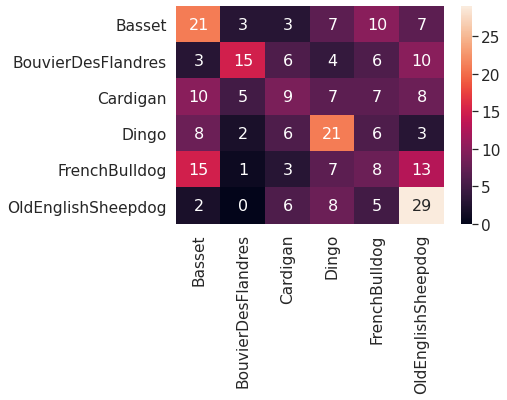

In [30]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), small_directory_names, small_directory_names)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()